# Analysis

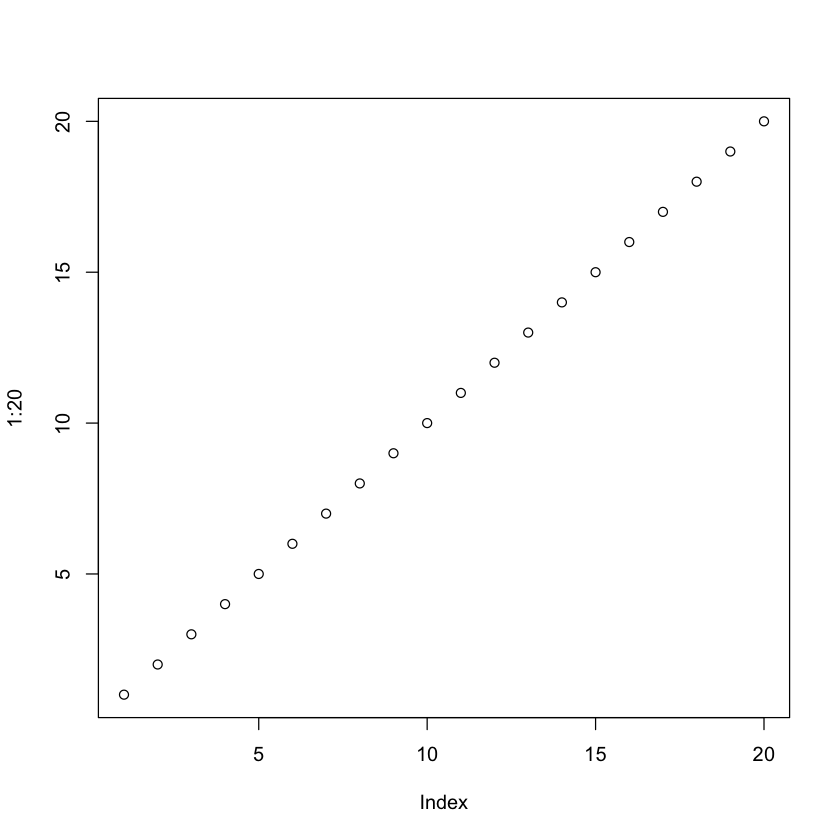

In [1]:
plot(1:20)

```{note}
This text is **standard** _Markdown_
```